In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math
from ordered_set import OrderedSet
np.seterr(divide = 'ignore') 
np.seterr(over="ignore")
np.seterr(all="ignore")
np.seterr(under="ignore")
np.seterr(invalid="ignore")
from pathlib import Path  
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
from pandas import Timestamp
from dateutil.rrule import rrule, MONTHLY
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import calendar
from datetime import datetime
import networkx as nx
import math 


In [28]:
cd ..

/Users/helensiavelis/Desktop/Caltech/Senior/Spring 2023/CS 145/CS-145


In [29]:
cd MarketMaven/data

/Users/helensiavelis/Desktop/Caltech/Senior/Spring 2023/CS 145/CS-145/MarketMaven/data


In [27]:
ls

NYSE_network_graph.dot     migrations/
S&P-500_network_graph.dot  networks.py
__init__.py                schemas.py
__pycache__/               static/
app.db                     templates/
config.py                  views.py
data/                      webapp.py
financial_models.py


# NYSE, NASDAQ, AMEX Graphs

In [30]:
data = pd.read_csv('monthly_stock.csv')
remove_indexes = data[data['returns'] == 0].index
data.drop(remove_indexes, inplace=True)

In [31]:
remove_indexes = data[(data['exchange'] != 'AMEX')].index
data.drop(remove_indexes, inplace=True)

In [32]:
set(data.exchange.values)

{'AMEX'}

In [33]:
data = data.drop("monthly_transaction_id", axis=1)
data = data.drop("price", axis=1)
data = data.drop("shares_outstanding", axis=1)
data = data.drop("share_type", axis=1)
data = data.drop("exchange", axis=1)

In [34]:
## drop out any stocks that are not currently in the database
# find the last index of each permno. if not in 2020-12-31, drop it 
for permno in set(data['permno'].values):
    last_index = data[data['permno'] == permno].tail(1)
    if last_index['date'].item() < '2020-12-31':
        remove_indexes = data[data['permno'] == permno].index
        data.drop(remove_indexes, inplace=True)
    

In [35]:
## Adds an edge if the correlation is greater than or equal to theta
def add_correlation_edges(graph, permnos, theta):
    for i in permnos:
        permno_i_data = data[data['permno']== i]
        for j in permnos:
            permno_j_data = data[data['permno']== j]
            intersection = list(OrderedSet(list(permno_i_data['date'].values)) & OrderedSet(list(permno_j_data['date'].values)))
            returns_i = list(permno_i_data[permno_i_data['date'].isin(intersection)]['returns'].values)
            returns_j = list(permno_j_data[permno_j_data['date'].isin(intersection)]['returns'].values)
            curr_corr = np.corrcoef(returns_i, returns_j)[1, 0]
            if i != j and abs(curr_corr) > theta:
                graph.add_edge(i, j)
    return graph
            
            

In [36]:
## Create a graph here and add all nodes 
g = nx.Graph()
g.add_nodes_from(list(set(data['permno'].values)))
g = add_correlation_edges(g, list(g.nodes), .9)
g.remove_nodes_from(list(nx.isolates(g)))

/Users/helensiavelis/miniforge3/lib/python3.9/site-packages/numpy/lib/function_base.py:2846: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(50, 50))
nx.draw(g)

In [ ]:
## convert graph to pandas adjacency list 
aj = nx.to_pandas_adjacency(g)

## write csv as pandas adjancey list 
filepath = Path('adj_matrix_AMEX.csv')  
aj.to_csv(filepath)

# Constructing Portfolios

In [33]:
## COMMENT OUT IF ALREADY HAVE GRAPH, THIS IS FOR RELOADING TO AVOID COMPUTING ABOVE AGAIN 
A1 = pd.read_csv("adj_matrix_AMEX.csv", index_col='index')
A2 = pd.DataFrame(A1.values, index=A1.columns, columns=A1.columns)
g = nx.from_pandas_adjacency(A2)

In [34]:
## Optimization problem for centrality coefficients 
def solve_optimization_problem():
    return 1/3  

In [35]:
## Find the average centralities of all stocks
def find_average_centralities(graph):
    average_centrailites = dict()
    scale_factor = solve_optimization_problem()
    
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    for node in graph.nodes():
        average_centrailites[node] = scale_factor * (degree_centrality[node] + closeness_centrality[node] + betweenness_centrality[node])        
    return average_centrailites

In [36]:
## return the long and short stocks
def get_long_short_stocks(top_percent, graph, c_avgs):
    
    ## add centralities into the graph 
    
    sorted_c_avgs_top = sorted(c_avgs, key=c_avgs.get, reverse=True)
    sorted_c_avgs_bottom = sorted(c_avgs, key=c_avgs.get, reverse=False)
    
    
    
    top_stocks = math.floor(top_percent * len(sorted_c_avgs_top))
    bottom_stocks = math.floor(top_percent * len(sorted_c_avgs_bottom))
    return sorted_c_avgs_top[:top_stocks], sorted_c_avgs_bottom[:bottom_stocks]


In [88]:
## find average centralities and portfolio (remove ones not in portfolio)
average_centralities = find_average_centralities(g)
long, short = get_long_short_stocks(.10, g, average_centralities)
nodes_to_remove = [node for node in list(g.nodes) if node not in long + short]


In [89]:
## write average_centralities into main dataframe 
tickers = pd.read_csv('current_crsp_tickers.csv')
coeffs = pd.DataFrame.from_dict({'permno': list(average_centralities.keys()), 'coeff': list(average_centralities.values())})
coeffs.permno = pd.to_numeric(coeffs.permno)
coeff_tickers = tickers.merge(coeffs, how='inner', on='permno')

## write csv as pandas adjancey list 
filepath = Path('coeffs.csv')  
coeff_tickers.to_csv(filepath)


In [37]:
#### remove all nodes from g that are not in the long short (COPIED VERSION)
g_copy = g.copy()
#g_copy.remove_nodes_from(nodes_to_remove)
#g_copy.remove_nodes_from(list(nx.isolates(g_copy)))

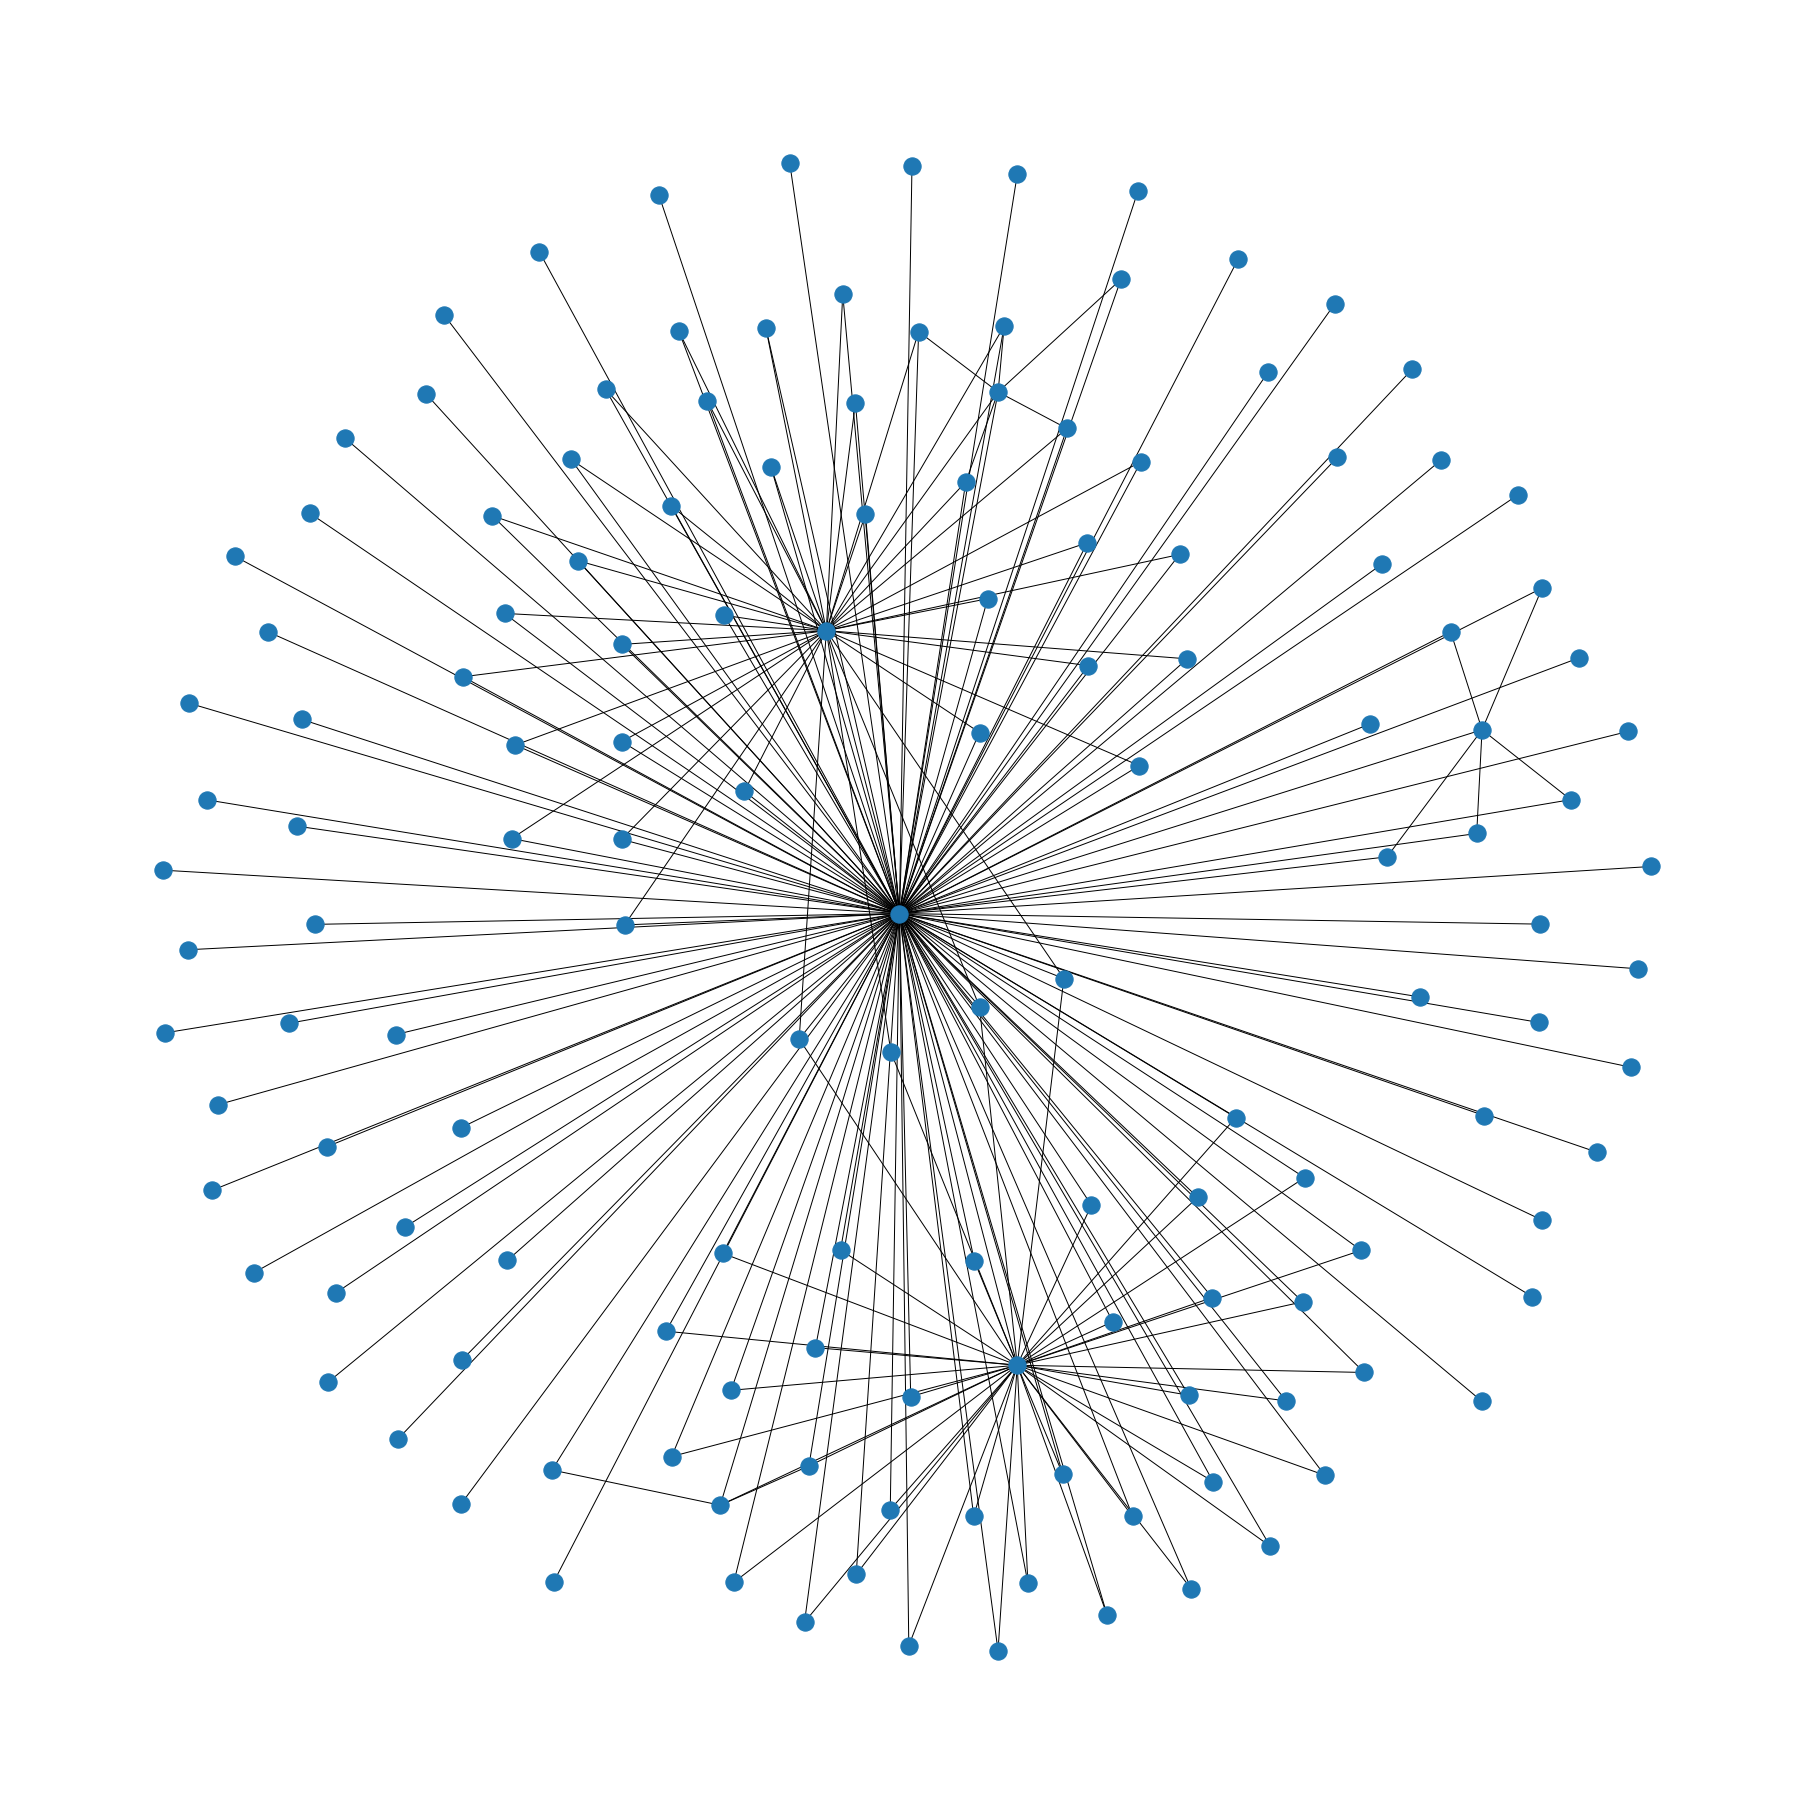

In [38]:
plt.figure(figsize=(25, 25))
nx.draw(g_copy)

# Portfolio Analysis

In [4]:
ls

adj_matrix.csv                   coeffs_AMEX.csv
adj_matrix_AMEX.csv              coeffs_NASDAQ.csv
adj_matrix_NASDAQ.csv            coeffs_NYSE.csv
adj_matrix_NASDAQ_AMEX.csv       current_crsp_tickers.csv
adj_matrix_NYSE.csv              monthly_stock.csv
adj_matrix_NYSE_NASDAQ_AMEX.csv  monthly_stock_ffm.csv
coeffs.csv


In [57]:
data = pd.read_csv('monthly_stock.csv')
nyse = pd.read_csv('coeffs_NYSE.csv', index_col='index')
nasdaq = pd.read_csv('coeffs_NASDAQ.csv', index_col='index')
amex = pd.read_csv('coeffs_AMEX.csv', index_col='index')
ffm = pd.read_csv('monthly_stock_ffm.csv')

nyse_data = data.merge(amex, how='inner', on='permno') #data.merge(nyse, how='inner', on='permno')
nasdaq_data = data.merge(nasdaq, how='inner', on='permno')
amex_data = data.merge(amex, how='inner', on='permno')

In [58]:
## At the last date, find the long/short portfolio - ASSUME NO REBALANCING HERE 
last_date = nyse_data[nyse_data['date'] == '2020-12-31']
last_date['decile'] = pd.qcut(last_date['coeff'].rank(method='first'), 10, labels=False)

long_stocks = list(last_date[last_date['decile'] == 9]['permno'].values)
short_stocks = list(last_date[last_date['decile'] == 0]['permno'].values)

nyse_data['size'] = nyse_data['shares_outstanding'] * nyse_data['price']

## create two differenet data frames, one for short and one for long 
nyse_short = nyse_data[nyse_data['permno'].isin(short_stocks)]
nyse_short = nyse_short.reset_index()
nyse_short = nyse_short.drop('index', axis=1)

nyse_long = nyse_data[nyse_data['permno'].isin(long_stocks)]
nyse_long = nyse_long.reset_index()
nyse_long = nyse_long.drop('index', axis=1)

In [59]:
def calc_weights(group):
    total_size = group['size'].sum()
    num_stocks = group['size'].count()
    group['eq_weight'] = 1/float(num_stocks)
    group['val_weight'] = group['size']/total_size
    return group

In [60]:
## find all weights and returns for both long, short portfolios
nyse_long = nyse_long.groupby('date', group_keys=True).apply(calc_weights)
nyse_short = nyse_short.groupby('date', group_keys=True).apply(calc_weights)

nyse_long['EQ'] = nyse_long['eq_weight'] * nyse_long['returns']
nyse_long['VAL'] = nyse_long['val_weight'] * nyse_long['returns']
nyse_short['EQ'] = nyse_short['eq_weight'] * nyse_short['returns']
nyse_short['VAL'] = nyse_short['val_weight'] * nyse_short['returns']

In [61]:
nyse_long

monthly_transaction_id  permno        date share_type  \
date                                                                    
2010-01-29 0                        79   83411  2010-01-29     Common   
           132                     396   13769  2010-01-29     Common   
           264                    3718   92345  2010-01-29     Common   
           396                    4030   90608  2010-01-29     Common   
2010-02-26 1                      5496   83411  2010-02-26     Common   
...                                ...     ...         ...        ...   
2020-12-31 885                  487751   19149  2020-12-31     Common   
           892                  488735   19417  2020-12-31     Common   
           898                  488235   19515  2020-12-31     Common   
           902                  488253   19778  2020-12-31     Common   
           906                  488232   19787  2020-12-31     Common   

               exchange    price   returns  shares_outstanding ticker_symbol  \
date                                                                           
2010-01-29 0       AMEX   4.5301  0.035688             27119.0           EPM   
           132     AMEX   2.6000 -0.118644              4595.0          AMSH   
           264     AMEX   2.3290  0.130583             23253.0           NBY   
           396     AMEX   0.4000  0.176471             67769.0           KOW   
2010-02-26 1       AMEX   4.4600 -0.015474             27161.0           EPM   
...                 ...      ...       ...                 ...           ...   
2020-12-31 885     AMEX   7.5400  0.383486              6892.0          ANVS   
           892     AMEX  10.2000  0.025126             10778.0          RCOR   
           898     AMEX   8.4200  0.403333              6111.0           POL   
           902     AMEX  47.3200 -0.022516              8875.0           LSF   
           906     AMEX  10.1400  0.029442             14375.0           PTK   

                   coeff         size  eq_weight  val_weight        EQ  \
date                                                                     
2010-01-29 0    0.175488  122851.7819   0.250000    0.568593  0.008922   
           132  0.175495   11947.0000   0.250000    0.055294 -0.029661   
           264  0.175488   54156.2370   0.250000    0.250651  0.032646   
           396  0.175488   27107.6000   0.250000    0.125462  0.044118   
2010-02-26 1    0.175488  121138.0600   0.250000    0.568255 -0.003868   
...                  ...          ...        ...         ...       ...   
2020-12-31 885  0.175488   51965.6800   0.066667    0.025850  0.025566   
           892  0.187471  109935.6000   0.066667    0.054687  0.001675   
           898  0.183905   51454.6200   0.066667    0.025596  0.026889   
           902  0.305682  419965.0000   0.066667    0.208910 -0.001501   
           906  0.301787  145762.5000   0.066667    0.072509  0.001963   

                     VAL  
date                      
2010-01-29 0    0.020292  
           132 -0.006560  
           264  0.032731  
           396  0.022140  
2010-02-26 1   -0.008793  
...                  ...  
2020-12-31 885  0.009913  
           892  0.001374  
           898  0.010324  
           902 -0.004704  
           906  0.002135  

[907 rows x 15 columns]

In [62]:
## Create a new returns table 
returns_table = pd.DataFrame()
returns_table['EQ_long'] = nyse_long['EQ'].groupby('date').sum() * 100
returns_table['EQ_short'] = nyse_short['EQ'].groupby('date').sum() * 100
returns_table['EQ'] = returns_table['EQ_long'] - returns_table['EQ_short'] 

returns_table['VAL_long'] = nyse_long['VAL'].groupby('date').sum() * 100
returns_table['VAL_short'] = nyse_short['VAL'].groupby('date').sum() * 100 
returns_table['VAL'] = returns_table['VAL_long'] - returns_table['VAL_short'] 

returns_table = returns_table.reset_index()

In [63]:
def get_month(row):
    return row[5:7]

def get_year(row):
    return row[0:4]

In [64]:
returns_table['month'] = returns_table['date'].apply(get_month)
returns_table['year'] = returns_table['date'].apply(get_year)

ffm['month'] = ffm['date'].apply(get_month)
ffm['year'] = ffm['date'].apply(get_year)

In [65]:
merged_data = returns_table.merge(ffm, how='inner', on=['month', 'year'])
merged_data = merged_data.drop(['date_x', 'year', 'month'], axis=1)
merged_data = merged_data.rename(columns={'date_y': 'Date'})
merged_data['EQ_RF'] = merged_data['EQ'] - merged_data['risk_free']

In [66]:
merged_data

,EQ_long,EQ_short,EQ,VAL_long,VAL_short,VAL,monthly_transaction_ffm_id,Date,market_minus_risk_free,small_minus_big,high_minus_low,risk_free,market_rate,EQ_RF
0,5.602450,6.954300,-1.351850,6.860272,-7.886082,14.746354,0,2010-01-31,-3.36,0.40,0.43,0.00,-3.36,-1.351850
1,1.257275,0.848221,0.409054,-1.291968,6.511305,-7.803274,1,2010-02-28,3.40,1.19,3.23,0.00,3.40,0.409054
2,-4.766480,12.615143,-17.381623,-0.660428,14.602024,-15.262453,2,2010-03-31,6.31,1.48,2.21,0.01,6.32,-17.391623
3,2.752440,7.879486,-5.127046,13.774683,5.725449,8.049234,3,2010-04-30,2.00,4.87,2.89,0.01,2.01,-5.137046
4,-6.082720,-7.605693,1.522973,-2.372775,-9.376009,7.003234,4,2010-05-31,-7.89,0.09,-2.44,0.01,-7.88,1.512973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,-5.249431,3.420927,-8.670357,4.377799,3.666990,0.710808,127,2020-08-31,7.63,-0.22,-2.96,0.01,7.64,-8.680357
128,-7.077300,-7.881993,0.804693,-2.641191,-7.160732,4.519541,128,2020-09-30,-3.63,0.04,-2.68,0.01,-3.62,0.794693
129,-2.301467,-0.121307,-2.180160,-1.019875,4.173104,-5.192980,129,2020-10-31,-2.10,4.37,4.22,0.01,-2.09,-2.190160
130,8.833820,19.608287,-10.774467,10.075709,19.458590,-9.382881,130,2020-11-30,12.47,5.81,2.13,0.01,12.48,-10.784467


In [67]:
## get long short to construct portfolio returns 

In [68]:
def compute_monthly_average(ret_col):
    return np.mean(ret_col)

def compute_monthly_volatility(data_lst):
    return np.std(data_lst)

def compute_monthly_sharpe_ratio(portfolio_return, rf):
    return ((np.mean(portfolio_return) - np.mean(rf))/np.std(portfolio_return))

In [69]:
print("MEAN MONTHLY RETURNS")
print(f"FF Equal Portfolio: {compute_monthly_average(merged_data['EQ'])}")
print()


print("MONTHLY VOLATILITY")
print(f"FF Equal Portfolio: {compute_monthly_volatility(merged_data['EQ'])}")
print()



print("MONTHLY SHARPE RATIO")
print(f"FF Equal Portfolio: {compute_monthly_sharpe_ratio(merged_data['EQ'], merged_data['risk_free'])}")
print()

MEAN MONTHLY RETURNS
FF Equal Portfolio: -0.34694624474010827

MONTHLY VOLATILITY
FF Equal Portfolio: 8.114292911389532

MONTHLY SHARPE RATIO
FF Equal Portfolio: -0.04798575691269604



In [70]:
################# CAPM #################
print("FF EQUAL PORTFOLIO")
model = smf.ols(formula='EQ_RF ~ market_minus_risk_free', data=merged_data).fit()
print(f"P Value: {model.pvalues[0]}")
print(f"Beta of the EQ Stratgey: {model.params[1]}")
print(f"Alpha of the EQ Stratgey: {model.params[0]}")    
beta_EQ = model.params[1]

FF EQUAL PORTFOLIO
P Value: 0.6835661869239448
Beta of the EQ Stratgey: -0.07467595704745197
Alpha of the EQ Stratgey: -0.30125851511783086


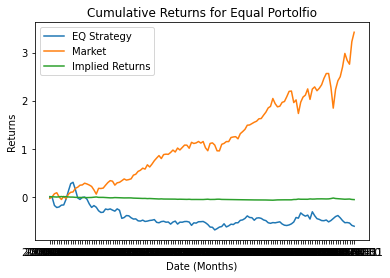

In [71]:
implied_returns = merged_data['risk_free'] + beta_EQ * merged_data['market_minus_risk_free']
plt.figure()
plt.plot(merged_data.Date, (1 + merged_data['EQ_RF']/100).cumprod() - 1)
plt.plot(merged_data.Date, (1 + merged_data['market_rate']/100).cumprod() - 1)
plt.plot(merged_data.Date, (1 + implied_returns/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title("Cumulative Returns for Equal Portolfio")
plt.legend(['EQ Strategy', 'Market', 'Implied Returns'])
plt.show() 